# Predicting JIA and Healthy Controls using XGBoost

In this notebook, we use the dataset [GSE112057](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE112057) to predict JIA patients and healthy control participants.  The datasets includes 115 JIA (juvenile idiopathic arthritis) patients, 75 J-IBD (juvenile inflammatory bowel disease) and 12 healthy controls.  We apply XGBoost (eXtreme Gradient Boosting) with a train and test split to the data.

We then use SHAP (SHapley Additive exPlanations) to explain the predictions of the model.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in clinical data and remove J-IBD samples
clin = pd.read_csv('data/GSE112057_clin.csv', index_col = 0, header = 0)
clin = clin[clin['Disease'] != 'JIBD']
clin.head()

,Sex,AgeAtDiagnosis,Race,Diagnosis,Disease
SUBJECT_ID,,,,,
Sample008,Female,12.0,White,Polyarticular JIA,JIA
Sample009,Male,9.0,White,Polyarticular JIA,JIA
Sample010,Female,14.0,White,Polyarticular JIA,JIA
Sample011,Female,8.0,White,Oligoarticular JIA,JIA
Sample012,Female,2.0,White,Oligoarticular JIA,JIA


In [3]:
# list of sample ids from row names 'SUBJECT_ID' in clin
sample_ids = clin.index.tolist()
sample_ids[:5]

['Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012']

In [4]:
# read in count data and select and order the columns according to the sample_ids
data = pd.read_csv('data/GSE112057_blood.csv', index_col = 0, header = 0)
data = data[sample_ids]
data = data.T
data.head()

ID_REF,ABCC2,ABI1,ABLIM1,ACADSB,ACBD5,ACSL5,ACTA2,ACTR1A,ADAM8,ADD3,...,ZFAND5,ZFP37,ZMYND19,ZNF169,ZNF189,ZNF367,ZNF484,ZNF510,ZNF782,ZNF79
Sample008,0.892,5.159,4.858,2.504,3.134,4.454,1.661,5.229,7.357,6.136,...,4.754,0.839,2.686,1.429,2.662,1.128,1.398,2.034,1.205,2.363
Sample009,0.743,5.117,5.072,2.539,3.283,4.638,1.070,5.417,7.106,6.186,...,4.937,0.697,2.634,1.499,2.742,1.245,1.609,2.193,1.423,2.286
Sample010,0.674,5.354,5.821,3.203,3.801,4.948,1.706,5.222,6.025,6.867,...,5.107,1.032,2.906,1.973,3.144,1.661,2.039,2.705,1.690,2.405
Sample011,0.711,5.225,5.146,2.547,3.285,4.451,1.169,5.095,6.878,6.457,...,4.824,0.922,2.607,1.507,2.883,1.311,1.603,2.385,1.265,2.199
Sample012,0.711,5.119,5.522,2.736,3.331,4.484,1.449,5.141,6.982,6.386,...,4.678,1.304,2.784,1.763,2.971,1.267,1.714,2.320,1.660,2.174


In [5]:
# in clin, create a new column for HC_JIA
# assign 1 to samples with 'JIA' in 'Disease' column and 0 to samples with 'HC'
clin['HC_JIA'] = np.where(clin['Disease'] == 'JIA', 1, 0)
clin.head()

,Sex,AgeAtDiagnosis,Race,Diagnosis,Disease,HC_JIA
SUBJECT_ID,,,,,,
Sample008,Female,12.0,White,Polyarticular JIA,JIA,1
Sample009,Male,9.0,White,Polyarticular JIA,JIA,1
Sample010,Female,14.0,White,Polyarticular JIA,JIA,1
Sample011,Female,8.0,White,Oligoarticular JIA,JIA,1
Sample012,Female,2.0,White,Oligoarticular JIA,JIA,1


In [6]:
# shape of clin
print("clin shape", clin.shape)

# classes in HC_JIA
print(" ")
print("bincount HC_JIA:", np.bincount(clin['HC_JIA']))

clin shape (127, 6)
 
bincount HC_JIA: [ 12 115]


## PCA and t-SNE plots

In [7]:
# Scale the data for PCA and t-SNE
data_scaled = StandardScaler().fit_transform(data)

In [8]:
# Prepare the first 2 PCA components and plot
pca_2c = PCA(n_components = 2)
pca_2c_features = pca_2c.fit_transform(data_scaled)

pca_2c_df = pd.DataFrame(
    data = pca_2c_features, 
    columns = ['PC1', 'PC2'])

target = list(clin['HC_JIA'])

pca_2c_df['target'] = target

expl_var = round(sum(pca_2c.explained_variance_ratio_) * 100, 2)

pca1_expl_var = round(pca_2c.explained_variance_ratio_[0] * 100, 2)
pca2_expl_var = round(pca_2c.explained_variance_ratio_[1] * 100, 2)



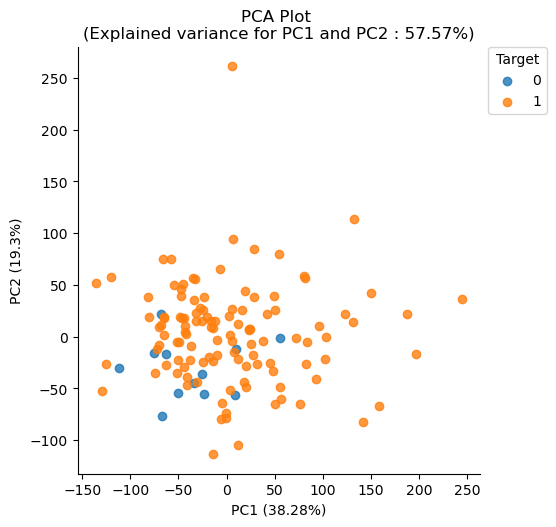

In [9]:
# Plot the first 2 PCA components
x_title = "PC1 (" + str(pca1_expl_var) + "%)"
y_title = "PC2 (" + str(pca2_expl_var) + "%)"

sub_title = "(Explained variance for PC1 and PC2 : " + str(expl_var) + "%)"
title = "PCA Plot \n" + sub_title

sns.lmplot(
    x = 'PC1', 
    y = 'PC2',
    data = pca_2c_df,
    hue = 'target',
    fit_reg = False,
    legend = False
)
plt.title(title)
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Target')
plt.xlabel(x_title)
plt.ylabel(y_title)
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


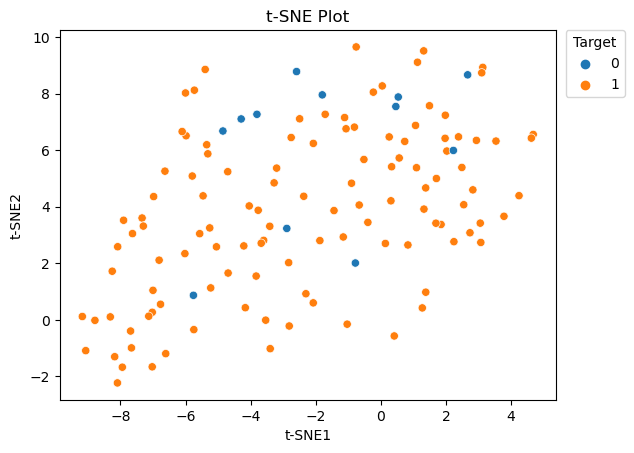

In [10]:
# t-SNE plot
tsne = TSNE(random_state=0)
tsne_results = tsne.fit_transform(data_scaled)
tsne_results = pd.DataFrame(tsne_results, columns = ['t-SNE1', 't-SNE2'])
tsne_results['target'] = target

sns.scatterplot(data = tsne_results, 
                x = "t-SNE1", 
                y = "t-SNE2",
                hue = 'target',
                legend = True
               )
plt.title('t-SNE Plot')
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Target')
plt.show()

## Train and test the model

In [11]:
# Assign response, and split data for train and test
y =  clin["HC_JIA"]
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y,
                                                    #stratify = y,
                                                    #shuffle = True,
                                                    test_size = 0.25, 
                                                    random_state = 132)   
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

X_train shape (95, 11923)
X_test shape (32, 11923)


In [12]:
# Initiate and train the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {'max_depth': 4,                       #  this has to be optimised for your model, range between 0->
         'eta': 0.5,                           #  this has to be optimised for your model, range between 0-1
         'objective': 'binary:logistic',       #  this depends on the nature of your model
        }

param['eval_metric'] = 'auc'                   #  this depends on the objective 
num_round = 100                                # number of rounds for boosting
evallist = [(dtest, 'eval'),(dtrain, 'train')] # eval test
progress = {}
model = xgb.train(param, dtrain, num_round, 
                     evals=evallist, evals_result = progress, 
                     verbose_eval=10, 
                     early_stopping_rounds=25) 

# classes in y_test
print(" ")
print("bincount y_test:", np.bincount(y_test))

[0]	eval-auc:0.56667	train-auc:1.00000
[10]	eval-auc:0.73333	train-auc:1.00000
[20]	eval-auc:0.73333	train-auc:1.00000
[25]	eval-auc:0.73333	train-auc:1.00000
 
bincount y_test: [ 5 27]


In [13]:
# Generate test predictions and assign to the nearest classification
preds = model.predict(dtest)
prediction =[]
for i in preds:
    if i >=0.5:
        prediction.append(1)
    else:
        prediction.append(0)
print("bincount prediction:", np.bincount(prediction))

bincount prediction: [ 3 29]


## Model performance

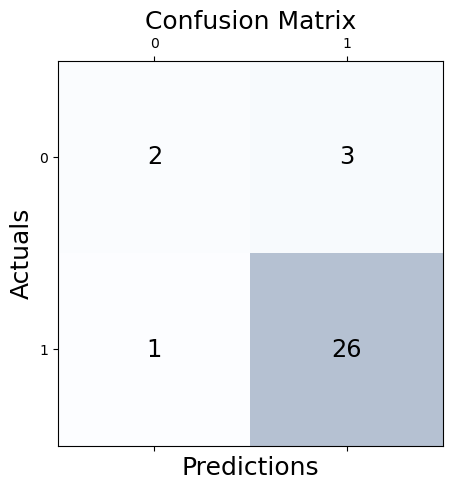

In [14]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = prediction)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [15]:
# Scores
print('Accuracy: %.3f' % accuracy_score(y_test, prediction))
print('F1 Score: %.3f' % f1_score(y_test, prediction))
print('Precision: %.3f' % precision_score(y_test, prediction))
print('Recall: %.3f' % recall_score(y_test, prediction))
print('ROC AUC: %.3f' % roc_auc_score(y_test, prediction))

Accuracy: 0.875
F1 Score: 0.929
Precision: 0.897
Recall: 0.963
ROC AUC: 0.681


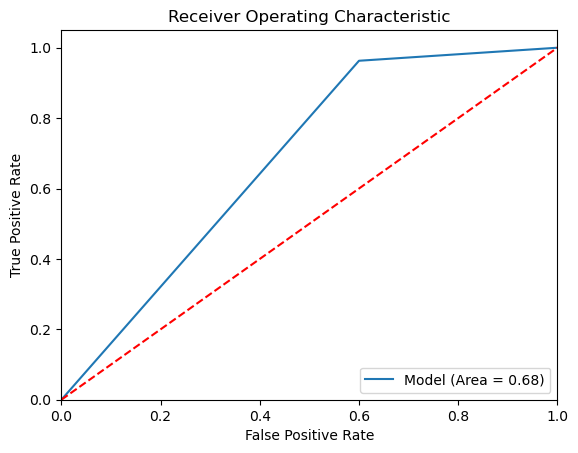

In [16]:
# ROC curve
y_true = np.array(y_test.values)
pred_array = np.array(prediction)
roc = roc_auc_score(y_true, pred_array)

fpr, tpr, thresholds = roc_curve(y_true, pred_array) 
plt.figure()
plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % roc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')
plt.show()


## Explaining the predictions using SHAP

A Shapley value is the average of the marginal contributions across all permuations.

The SHAP (SHapley Additive exPlanation) value plot can show the positive and negative relationships of the predictors with the target variable. The plot is made of all the dots in the train data. It delivers the following information:

Feature importance: Variables are ranked in descending order Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction Original value: Colour shows whether that variable is high (in red) or low (in blue) for that observation Correlation: If a feature is positively correlated to the target, a value higher than its own average will contribute positively to the prediction. Similarly, if a feature is negatively correlated to the target, a value higher than its own average will contribute negatively to the prediction

### SHAP summary plot

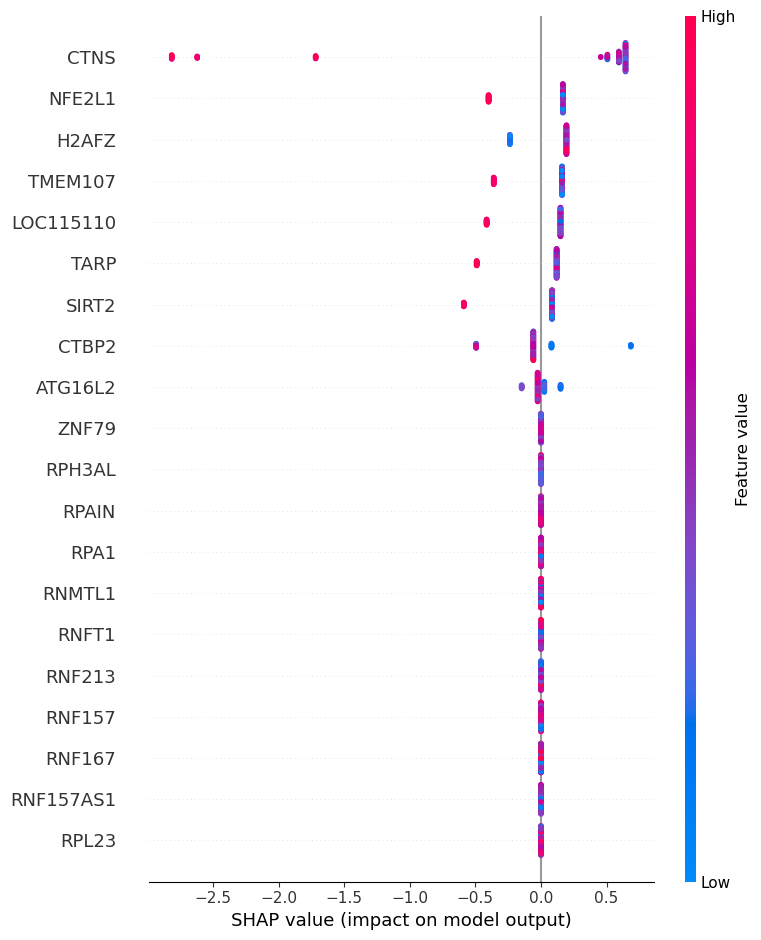

In [17]:
shap.initjs()

# Apply the generated model to the whole dataset and calculate the shap values
shap_values = shap.TreeExplainer(model).shap_values(data)  
explainer = shap.TreeExplainer(model, data)
expected_value = explainer.expected_value

features = data.columns

# Convert data DF to array
data_ = data.to_numpy()

# Run predictions for the whole dataset
d_data = xgb.DMatrix(data, label=y)

preds_data = model.predict(d_data)
prediction_data =[]
for i in preds_data:
    if i >=0.5:
        prediction_data.append(1)
    else:
        prediction_data.append(0)

# Print the shap summary plot
shap.summary_plot(shap_values, data, feature_names=data.columns) 


### SHAP force plots

Each feature has a shap value contributing to the prediction

The final prediction = the average prediction + the shap values of all features

The output value (f(x)) is the prediction for that observation

The base value is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat)

Red/Blue: features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue

In [18]:
# A function that displays the actual value and the predicted value to the force plot
# Adapted from Max Steele def shap_force 
# https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

def shap_accuracy(prediction_list, index, y_values):
    pred = prediction_list[index]
    
    true_label = y_values[index]
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct'
    else:
        accurate = 'Incorrect'
        
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    print('***'*12)
    print()

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



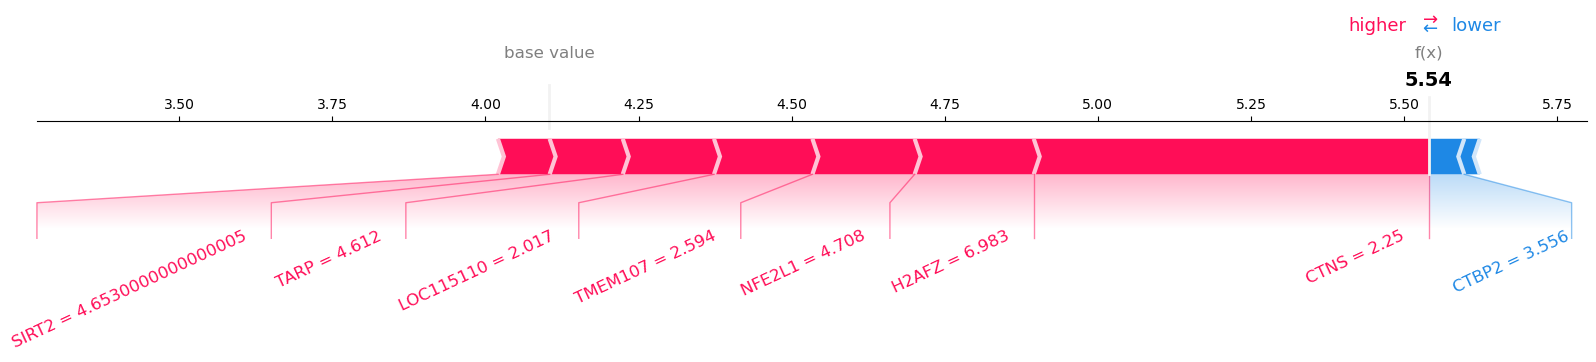

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



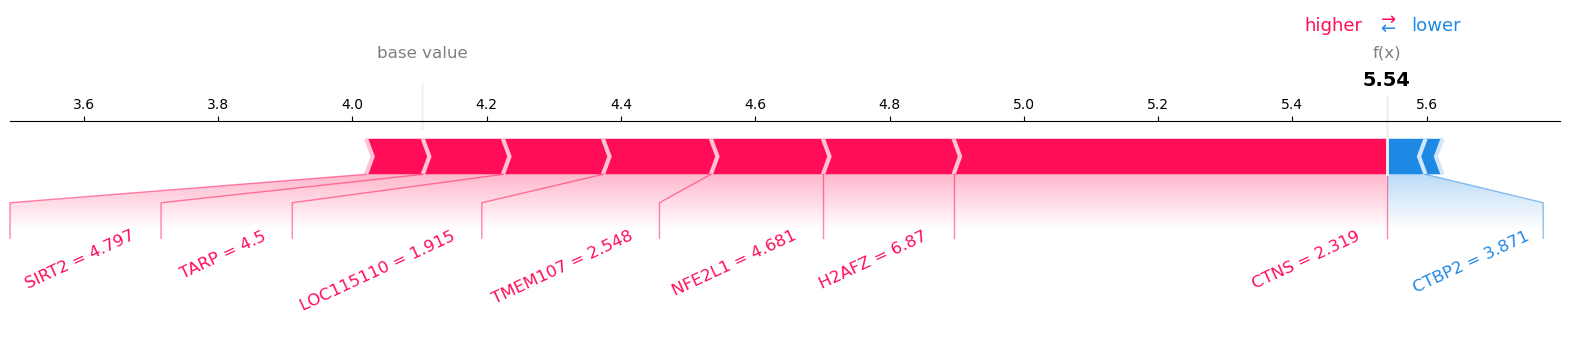

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



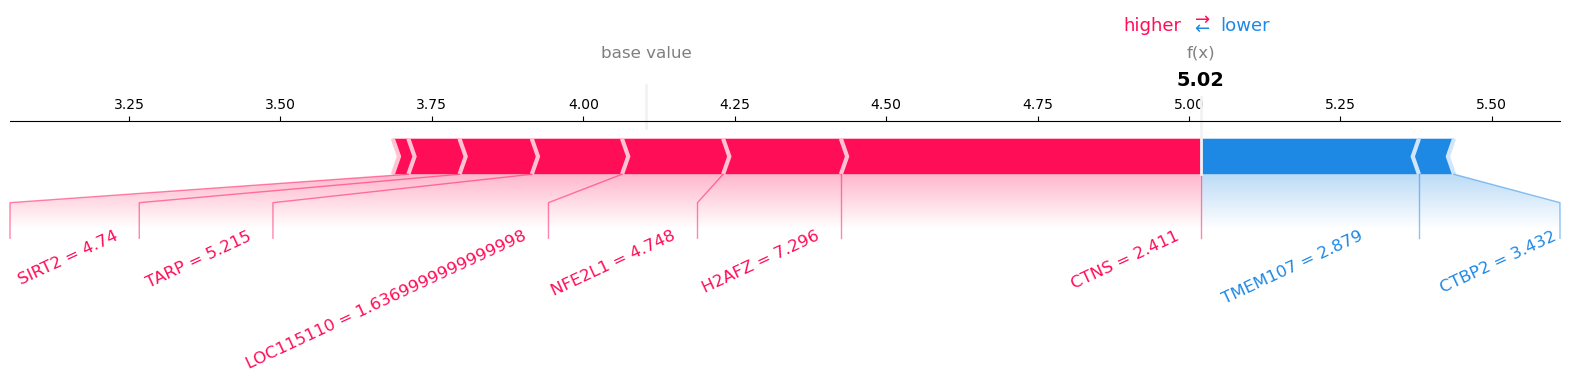

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



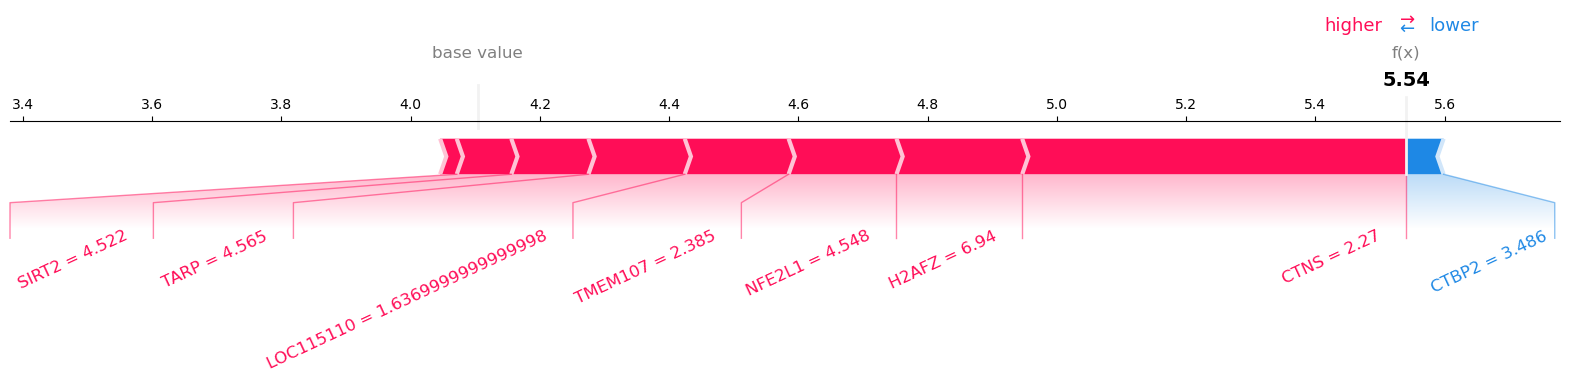

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



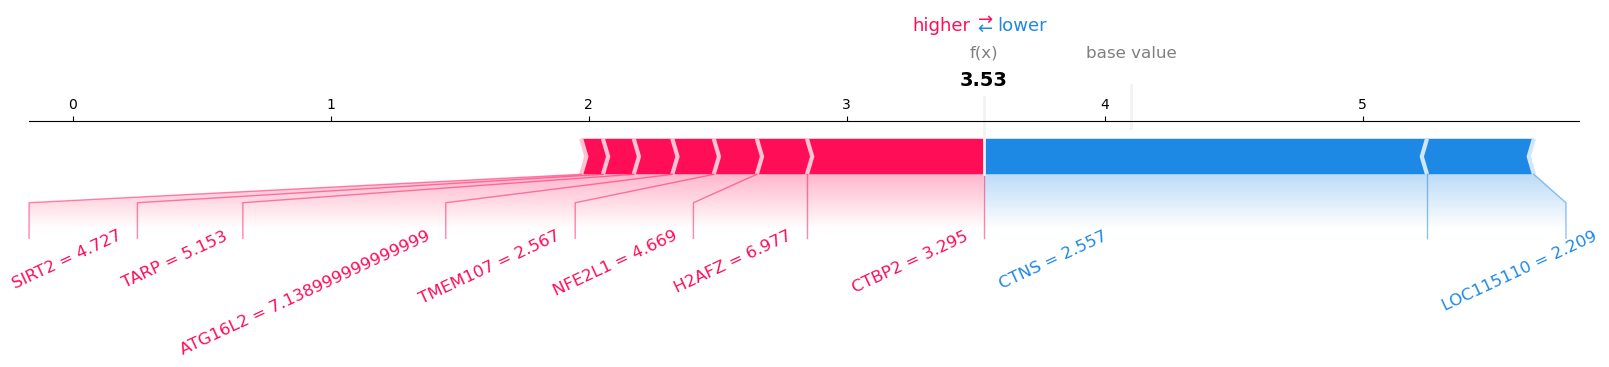

In [19]:
# display force plots for the first 5 samples

for i in range(5):
    shap_accuracy(prediction_data, i, y)
    shap.force_plot(expected_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)